In [1]:

import numpy as np
from scipy.signal import resample

# Load the data
#avg_entries = np.load("../../../sca101/generators/new_entries.npy")
#subset_traces = np.load("../../../sca101/generators/averaged_traces1000-0.890.npy")
#avg_entries = np.load("destination/folder/var_0/inputs.npy")
#subset_traces = np.load("destination/folder/var_0/traces.npy")
avg_entries = np.load("avg_entries.npy")
subset_traces = np.load("avg_traces.npy")
# Select 50 inputs and their corresponding traces without limiting the number of points
selected_avg_entries = avg_entries[:3000]
selected_subset_traces = subset_traces[:3000]

# Resample the traces to 5000 points
resampled_subset_traces = resample(selected_subset_traces, 5000, axis=1)

# Data cleaning: Remove NaN and extreme values

# Remove NaN values from selected_avg_entries
nan_indices = np.argwhere(np.isnan(selected_avg_entries))
cleaned_avg_entries = np.delete(selected_avg_entries, nan_indices, axis=0)

# Remove corresponding traces
cleaned_subset_traces = np.delete(resampled_subset_traces, nan_indices, axis=0)

#np.save("cleaned_avg_entries300.npy", cleaned_avg_entries)

#np.save("cleaned_avg_traces300.npy", cleaned_subset_traces)

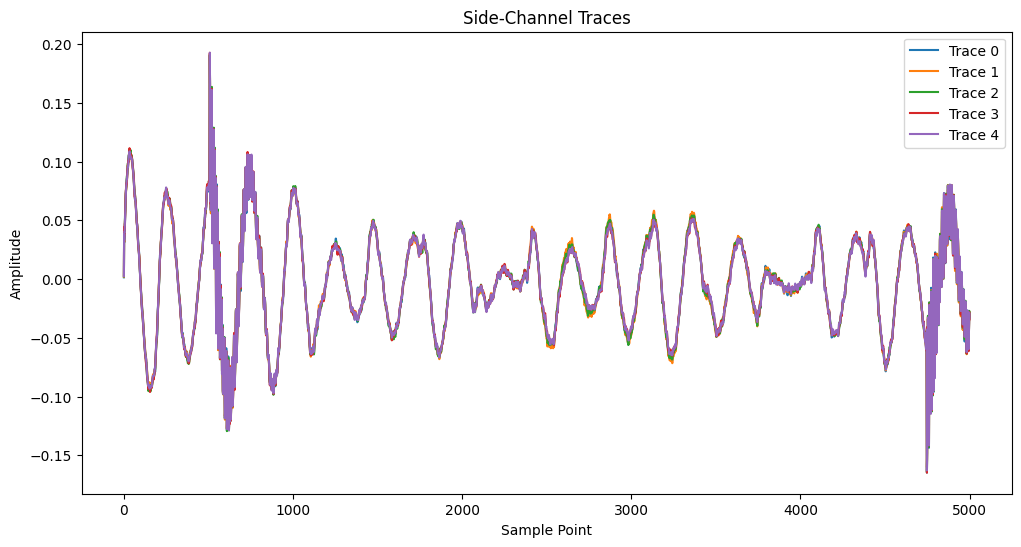

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import struct

traces = cleaned_subset_traces
inputs = cleaned_avg_entries

    
# Visualize some traces
plt.figure(figsize=(12, 6))
for i in range(5):  # Adjust the range as needed
    plt.plot(traces[i], label=f'Trace {i}')
plt.title('Side-Channel Traces')
plt.xlabel('Sample Point')
plt.ylabel('Amplitude')
plt.legend()
plt.show()






Processing trace counts:   0%|          | 0/21 [00:00<?, ?it/s]

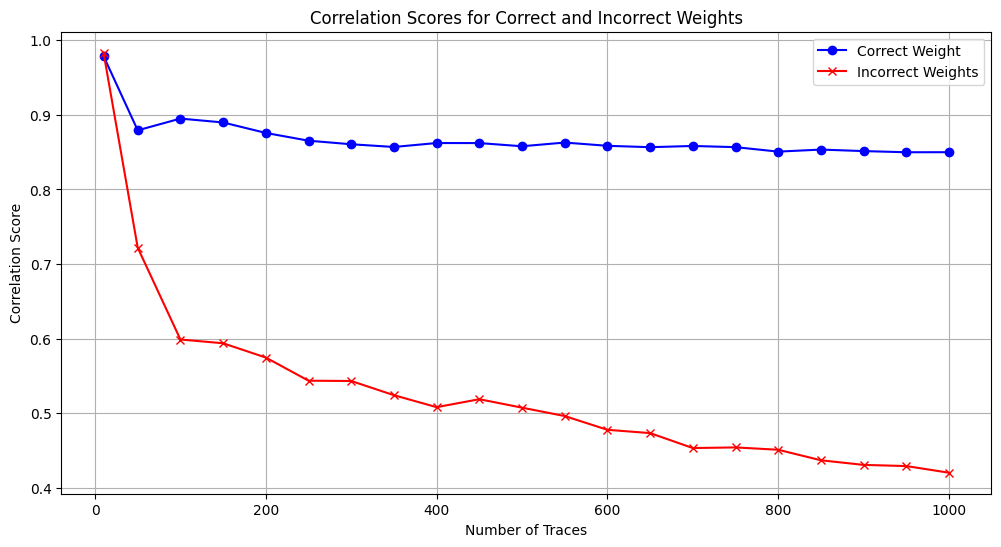

In [3]:
import numpy as np
import struct
from scipy.stats import pearsonr
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Define functions for CPA analysis
def float_to_binary(num):
    return ''.join(f'{c:08b}' for c in struct.pack('!f', num))

def hamming_weight(binary_str):
    return binary_str.count('1')

def calculate_correlations_for_weight(subset_traces, subset_inputs, weight):
    hws = np.array([hamming_weight(float_to_binary(input_value * weight)) for input_value in subset_inputs])
    correlations = np.array([pearsonr(subset_traces[:, sample_point], hws)[0] for sample_point in range(subset_traces.shape[1])])
    correlations = np.nan_to_num(correlations)
    return np.max(np.abs(correlations))

# Function to evaluate correlation differences and return scores
def evaluate_correlation_differences(subset_inputs, subset_traces, correct_weight, incorrect_weights):
    num_cores = 12  # Adjust based on your machine's capabilities
    
    # Calculate correlation for correct weight
    correct_correlation = calculate_correlations_for_weight(subset_traces, subset_inputs, correct_weight)
    
    # Calculate correlations for incorrect weights using multiprocessing
    incorrect_correlations = Parallel(n_jobs=num_cores)(delayed(calculate_correlations_for_weight)(subset_traces, subset_inputs, weight) for weight in incorrect_weights)

    max_incorrect_correlation = max(incorrect_correlations)
    return correct_correlation, max_incorrect_correlation, correct_correlation - max_incorrect_correlation



# Set the correct and incorrect weights
correct_weight = 0.793281  # Correct weight
incorrect_weights = np.linspace(0, 5, 500)  # Range of incorrect weights

# Set the range of trace counts to evaluate
trace_counts = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

# Iterate over different trace counts and store correlation scores
correct_scores = []
incorrect_scores = []
correlation_differences = []
threshold = 0.01  # Set a threshold for distinguishing correct weight
for count in tqdm(trace_counts, desc='Processing trace counts'):
    subset_traces = traces[:count, :]
    subset_inputs = inputs[:count]
    correct_corr, incorrect_corr, difference = evaluate_correlation_differences(subset_inputs, subset_traces, correct_weight, incorrect_weights)
    correct_scores.append(correct_corr)
    incorrect_scores.append(incorrect_corr)
    correlation_differences.append(difference)

# Plot the correlation scores for correct and incorrect weights
plt.figure(figsize=(12, 6))
plt.plot(trace_counts, correct_scores, marker='o', color='blue', label='Correct Weight')
plt.plot(trace_counts, incorrect_scores, marker='x', color='red', label='Incorrect Weights')
plt.xlabel('Number of Traces')
plt.ylabel('Correlation Score')
plt.title('Correlation Scores for Correct and Incorrect Weights')
plt.legend()
plt.grid(True)
plt.show()
